In [2]:
import squidpy as sq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import numpy as np

In [3]:
sc.settings.verbosity = 3  
# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=True, figsize=(5, 5))

-----
anndata     0.9.1
scanpy      1.9.3
-----
PIL                         9.1.1
PyQt5                       NA
anyio                       NA
appdirs                     1.4.4
asciitree                   NA
attr                        21.2.0
babel                       2.9.1
backcall                    0.2.0
build                       0.8.0
cachey                      0.2.1
certifi                     2022.06.15
cffi                        1.15.0
charset_normalizer          2.0.7
cloudpickle                 2.1.0
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.12.1
dask                        2023.5.1
dask_image                  2022.09.0
dateutil                    2.8.2
debugpy                     1.5.0
decorator                   5.1.1
defusedxml                  0.7.1
docrep                      0.3.2
docstring_parser            NA
entrypoints                 0.3
fasteners                   0.18
fastjsonschema              NA
filel

In [4]:
samples_dict = {"Immature": "A0021_043", "0hr": "A0008_041", "1hr": "A0021_044", "4hr": "A0008_045", "4hr_replicate": "A0021_042", "6hr": "A0021_045", "8hr": "A0008_044", "8hr_replicate": "A0021_038", "11hr": "A0008_046", "12hr": "A0021_046"}

In [5]:
s_genes = list(pd.read_csv("./../../MouseInfection/s.genes.txt")["x"])
g2m_genes = list(pd.read_csv("./../../MouseInfection/g2m.genes.txt")["x"])
print(s_genes)
print(g2m_genes)

['Mcm4', 'Exo1', 'Slbp', 'Gmnn', 'Cdc45', 'Msh2', 'Mcm6', 'Rrm2', 'Pold3', 'Blm', 'Ubr7', 'Mcm5', 'Clspn', 'Hells', 'Nasp', 'Rpa2', 'Rad51ap1', 'Tyms', 'Rrm1', 'Rfc2', 'Prim1', 'Brip1', 'Usp1', 'Ung', 'Pola1', 'Mcm2', 'Fen1', 'Tipin', 'Pcna', 'Cdca7', 'Uhrf1', 'Casp8ap2', 'Cdc6', 'Dscc1', 'Wdr76', 'E2f8', 'Dtl', 'Ccne2', 'Atad2', 'Gins2', 'Chaf1b', 'Pcna-ps2']
['Nuf2', 'Psrc1', 'Ncapd2', 'Ccnb2', 'Smc4', 'Lbr', 'Tacc3', 'Cenpa', 'Kif23', 'Cdca2', 'Anp32e', 'G2e3', 'Cdca3', 'Anln', 'Cenpe', 'Gas2l3', 'Tubb4b', 'Cenpf', 'Dlgap5', 'Hjurp', 'Cks1brt', 'Gtse1', 'Bub1', 'Birc5', 'Ube2c', 'Rangap1', 'Hmmr', 'Ect2', 'Tpx2', 'Ckap5', 'Cbx5', 'Nek2', 'Ttk', 'Cdca8', 'Nusap1', 'Ctcf', 'Cdc20', 'Cks2', 'Mki67', 'Tmpo', 'Ckap2l', 'Aurkb', 'Kif2c', 'Cdk1', 'Kif20b', 'Top2a', 'Aurka', 'Ckap2', 'Hmgb2', 'Cdc25c', 'Ndc80', 'Kif11']


In [313]:
adata_ovary_combined = sc.read_h5ad("./../pyobjs/adata_ovary_combined_processed_deconvoluted_newscaling.h5ad")
print(adata_ovary_combined.shape)

(158309, 2537)


In [314]:
adata_ovary_combined.obs["FollicleNumber"] = sc.read_h5ad("./../pyobjs/adata_ovary_combined_napari_processed.h5ad").obs["FollicleNumber"]
mode_df = pd.read_csv("./../pyobjs/follicle_mode.csv")
mode_df = mode_df.drop(columns=["Sample"])
adata_ovary_combined.obs = adata_ovary_combined.obs.join(mode_df.set_index('FollicleNumber'), on='FollicleNumber')
adata_ovary_combined.obs["Follicle_type"] = adata_ovary_combined.obs["Follicle_type"].astype("category")
print(adata_ovary_combined.obs["Follicle_type"].cat.categories)
adata_ovary_combined.obs["Follicle_type"].cat.reorder_categories(
    new_categories = ['Preantral', 'Antral', 'Atretic', 'Lytic'], inplace = True)

Index(['Antral', 'Atretic', 'Lytic', 'Preantral'], dtype='object')


/tmp/ipykernel_4011/1722826103.py:7: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata_ovary_combined.obs["Follicle_type"].cat.reorder_categories(


In [316]:
granulosa_combined = sc.read_h5ad("./../pyobjs/granulosa_individual_combined_newscaling.h5ad")
mesenchyme_combined = sc.read_h5ad("./../pyobjs/mesenchyme1.h5ad")

print(granulosa_combined.shape)
print(mesenchyme_combined.shape)

(83134, 31053)
(47814, 3744)


In [317]:
adata_ovary_combined.obs["Celltypes"] = [x.split("_")[1] for x in adata_ovary_combined.obs["Level0_max_pred_celltype"]]
adata_ovary_combined.obs["Celltypes"] = adata_ovary_combined.obs["Celltypes"].astype(str)
adata_ovary_combined.obs.loc[granulosa_combined.obs_names,"Celltypes"] = granulosa_combined.obs["granulosa_celltypes_reduced"]
adata_ovary_combined.obs.loc[mesenchyme_combined.obs_names,"Celltypes"] = mesenchyme_combined.obs["mesenchyme_max_pred_celltype_reduced"]
adata_ovary_combined.obs["Celltypes"] = adata_ovary_combined.obs["Celltypes"].astype("category")

In [1239]:
cumulus_bulk_raw_counts[cumulus_bulk_raw_counts.obs["Sample"] == "12hr"].obs["Follicle_type"]

FollicleNumber
Follicle396    Antral
Follicle399    Antral
Follicle408    Antral
Name: Follicle_type, dtype: category
Categories (1, object): ['Antral']

In [1231]:
oocytes = sc.read_h5ad("./../pyobjs/oocytes_bulk_combined.h5ad").raw.to_adata()
print(oocytes.shape)

cumulus_bulk_raw_counts = sc.read_h5ad("./../pyobjs/cumulus_bulk_raw_counts.h5ad")
sc.pp.normalize_total(cumulus_bulk_raw_counts, target_sum = 1e4, inplace=True)
sc.pp.log1p(cumulus_bulk_raw_counts)
print(cumulus_bulk_raw_counts.shape)

(90, 31053)
normalizing counts per cell
    finished (0:00:00)
(54, 31053)


/home/mm2937/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [1232]:
follicle_list = np.intersect1d(oocytes.obs["FollicleNumber"].values, cumulus_bulk_raw_counts.obs["FollicleNumber"].values)
print(follicle_list)
print(len(follicle_list))

['Follicle102' 'Follicle129' 'Follicle142' 'Follicle144' 'Follicle152'
 'Follicle156' 'Follicle164' 'Follicle232' 'Follicle240' 'Follicle244'
 'Follicle248' 'Follicle250' 'Follicle259' 'Follicle278' 'Follicle291'
 'Follicle300' 'Follicle301' 'Follicle356' 'Follicle372' 'Follicle373'
 'Follicle381' 'Follicle385' 'Follicle396' 'Follicle399' 'Follicle408']
25


In [1233]:
adata_dict = dict()
for follicle in follicle_list:
    adata_dict[follicle] = adata_ovary_combined.raw.to_adata()[adata_ovary_combined.obs["FollicleNumber"] == follicle]
    adata_dict[follicle].uns['log1p'] = {'base' : None}

/tmp/ipykernel_4011/1671682201.py:4: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_dict[follicle].uns['log1p'] = {'base' : None}


In [1234]:
adata_dict

{'Follicle102': AnnData object with n_obs × n_vars = 553 × 31053
     obs: 'barcode', 'x', 'y', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'individual_leiden_1.0', 'individual_leiden_1.2', 'individual_leiden_1.5', 'Sample', 'S_score', 'G2M_score', 'phase', 'leiden_1.0', 'leiden_1.5', 'Level1_total_abundance', 'Level1_EN_Blood', 'Level1_EN_Lymph', 'Level1_Epithelium', 'Level1_GC_Antral', 'Level1_GC_Atretic', 'Level1_GC_CL_Active', 'Level1_GC_CL_Lytic', 'Level1_GC_Estrous', 'Level1_GC_Mitotic', 'Level1_GC_Mural', 'Level1_GC_Preantral', 'Level1_I_B_Cell', 'Level1_I_Dendritic_Cell', 'Level1_I_Granulocyte', 'Level1_I_Macrophage', 'Level1_I_T_Cell', 'Level1_M_Cortical Stroma', 'Level1_M_Dividing Mesenchyme', 'Level1_M_Immature Theca', 'Level1_M_Medullary Stroma', 'Level1_M_Pericyte', 'Level1_M_Smooth Muscle', 'Level1_M_Steroidogenic Theca', 'Level1_Oocyte', 'Level1_max_pred', 'Level1_max_pred_celltype', 'Level1_max_pred_celltype_group', 'Level0_total

In [1235]:
for follicle in follicle_list:
#   adata_dict[sample] = adata_ovary_combined[adata_ovary_combined.obs["Sample"] == "sample"]
#   adata_dict[sample].uns['log1p'] = {'base' : None}
    print(adata_dict[follicle].shape)
    adata_dict[follicle].obs["Celltypes"] = adata_dict[follicle].obs["Celltypes"].astype("str")
    adata_dict[follicle].obs["Celltypes"] = adata_dict[follicle].obs["Celltypes"].astype("category")
    sq.gr.spatial_neighbors(adata_dict[follicle], coord_type="generic", radius=100)
    sq.gr.nhood_enrichment(adata_dict[follicle], cluster_key="Celltypes")

(553, 31053)
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating neighborhood enrichment using `1` core(s)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['Celltypes_nhood_enrichment']`
Finish (0:00:00)
(713, 31053)
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating neighborhood enrichment using `1` core(s)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['Celltypes_nhood_enrichment']`
Finish (0:00:00)
(900, 31053)
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating neighborhood enrichment using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_nhood.py:185: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['Celltypes_nhood_enrichment']`
Finish (0:00:00)
(769, 31053)
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating neighborhood enrichment using `1` core(s)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['Celltypes_nhood_enrichment']`
Finish (0:00:00)
(502, 31053)
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating neighborhood enrichment using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_nhood.py:185: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['Celltypes_nhood_enrichment']`
Finish (0:00:00)
(814, 31053)
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating neighborhood enrichment using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_nhood.py:185: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['Celltypes_nhood_enrichment']`
Finish (0:00:00)
(708, 31053)
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating neighborhood enrichment using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_nhood.py:185: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['Celltypes_nhood_enrichment']`
Finish (0:00:00)
(886, 31053)
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating neighborhood enrichment using `1` core(s)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['Celltypes_nhood_enrichment']`
Finish (0:00:00)
(712, 31053)
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating neighborhood enrichment using `1` core(s)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['Celltypes_nhood_enrichment']`
Finish (0:00:00)
(589, 31053)
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating neighborhood enrichment using `1` core(s)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['Celltypes_nhood_enrichment']`
Finish (0:00:00)
(542, 31053)
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating neighborhood enrichment using `1` core(s)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['Celltypes_nhood_enrichment']`
Finish (0:00:00)
(514, 31053)
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating neighborhood enrichment using `1` core(s)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['Celltypes_nhood_enrichment']`
Finish (0:00:00)
(682, 31053)
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating neighborhood enrichment using `1` core(s)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['Celltypes_nhood_enrichment']`
Finish (0:00:00)
(406, 31053)
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating neighborhood enrichment using `1` core(s)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['Celltypes_nhood_enrichment']`
Finish (0:00:00)
(472, 31053)
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating neighborhood enrichment using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_nhood.py:185: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['Celltypes_nhood_enrichment']`
Finish (0:00:00)
(425, 31053)
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating neighborhood enrichment using `1` core(s)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['Celltypes_nhood_enrichment']`
Finish (0:00:00)
(104, 31053)
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating neighborhood enrichment using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_nhood.py:185: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['Celltypes_nhood_enrichment']`
Finish (0:00:00)
(494, 31053)
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating neighborhood enrichment using `1` core(s)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['Celltypes_nhood_enrichment']`
Finish (0:00:00)
(70, 31053)
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating neighborhood enrichment using `1` core(s)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['Celltypes_nhood_enrichment']`
Finish (0:00:00)
(455, 31053)
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating neighborhood enrichment using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_nhood.py:185: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['Celltypes_nhood_enrichment']`
Finish (0:00:00)
(554, 31053)
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating neighborhood enrichment using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_nhood.py:185: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['Celltypes_nhood_enrichment']`
Finish (0:00:01)
(496, 31053)
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating neighborhood enrichment using `1` core(s)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['Celltypes_nhood_enrichment']`
Finish (0:00:00)
(618, 31053)
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating neighborhood enrichment using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_nhood.py:185: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['Celltypes_nhood_enrichment']`
Finish (0:00:00)
(619, 31053)
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating neighborhood enrichment using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_nhood.py:185: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['Celltypes_nhood_enrichment']`
Finish (0:00:00)
(668, 31053)
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating neighborhood enrichment using `1` core(s)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['Celltypes_nhood_enrichment']`
Finish (0:00:00)


In [1236]:
# samples_dict = {"0hr": "A0008_041", "1hr": "A0021_044", "4hr_replicate": "A0021_042", "6hr": "A0021_045", "8hr": "A0008_044", "11hr": "A0008_046", "12hr": "A0021_046"}
for follicle in follicle_list:
    print(adata_dict[follicle].shape)
    sq.gr.ligrec(
    adata_dict[follicle],
    use_raw=False,
    n_perms=100,
    cluster_key="Celltypes",
    clusters=["GC_Cumulus-(Mixed)", "Oocyte"],
    corr_method="bonferroni",
    corr_axis="interactions", 
    threshold = 0.00    
)

(553, 31053)
Fetching interactions from `omnipath`
Fetched `10935` interactions
    Finish (0:00:04)
Running `100` permutations on `7951` interactions and `4` cluster combinations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = data["clusters"].cat.remove_unused_categories()
/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = cat.rename_categories(cluster_mapper)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Performing FDR correction across the `interactions` using method `bonferroni` at level `0.05`
Adding `adata.uns['Celltypes_ligrec']`
Finish (0:00:05)
(713, 31053)
Fetching interactions from `omnipath`
Fetched `10935` interactions
    Finish (0:00:04)
Running `100` permutations on `7938` interactions and `4` cluster combinations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = data["clusters"].cat.remove_unused_categories()
/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = cat.rename_categories(cluster_mapper)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Performing FDR correction across the `interactions` using method `bonferroni` at level `0.05`
Adding `adata.uns['Celltypes_ligrec']`
Finish (0:00:05)
(900, 31053)
Fetching interactions from `omnipath`
Fetched `10935` interactions
    Finish (0:00:04)
Running `100` permutations on `7946` interactions and `4` cluster combinations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = data["clusters"].cat.remove_unused_categories()
/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = cat.rename_categories(cluster_mapper)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Performing FDR correction across the `interactions` using method `bonferroni` at level `0.05`
Adding `adata.uns['Celltypes_ligrec']`
Finish (0:00:05)
(769, 31053)
Fetching interactions from `omnipath`
Fetched `10935` interactions
    Finish (0:00:03)
Running `100` permutations on `7984` interactions and `4` cluster combinations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = data["clusters"].cat.remove_unused_categories()
/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = cat.rename_categories(cluster_mapper)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Performing FDR correction across the `interactions` using method `bonferroni` at level `0.05`
Adding `adata.uns['Celltypes_ligrec']`
Finish (0:00:04)
(502, 31053)
Fetching interactions from `omnipath`
Fetched `10935` interactions
    Finish (0:00:03)
Running `100` permutations on `7946` interactions and `4` cluster combinations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = data["clusters"].cat.remove_unused_categories()
/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = cat.rename_categories(cluster_mapper)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Performing FDR correction across the `interactions` using method `bonferroni` at level `0.05`
Adding `adata.uns['Celltypes_ligrec']`
Finish (0:00:05)
(814, 31053)
Fetching interactions from `omnipath`
Fetched `10935` interactions
    Finish (0:00:03)
Running `100` permutations on `7963` interactions and `4` cluster combinations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = data["clusters"].cat.remove_unused_categories()
/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = cat.rename_categories(cluster_mapper)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Performing FDR correction across the `interactions` using method `bonferroni` at level `0.05`
Adding `adata.uns['Celltypes_ligrec']`
Finish (0:00:04)
(708, 31053)
Fetching interactions from `omnipath`
Fetched `10935` interactions
    Finish (0:00:03)
Running `100` permutations on `7940` interactions and `4` cluster combinations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = data["clusters"].cat.remove_unused_categories()
/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = cat.rename_categories(cluster_mapper)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Performing FDR correction across the `interactions` using method `bonferroni` at level `0.05`
Adding `adata.uns['Celltypes_ligrec']`
Finish (0:00:05)
(886, 31053)
Fetching interactions from `omnipath`
Fetched `10935` interactions
    Finish (0:00:04)
Running `100` permutations on `8015` interactions and `4` cluster combinations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = data["clusters"].cat.remove_unused_categories()
/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = cat.rename_categories(cluster_mapper)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Performing FDR correction across the `interactions` using method `bonferroni` at level `0.05`
Adding `adata.uns['Celltypes_ligrec']`
Finish (0:00:05)
(712, 31053)
Fetching interactions from `omnipath`
Fetched `10935` interactions
    Finish (0:00:04)
Running `100` permutations on `7982` interactions and `4` cluster combinations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = data["clusters"].cat.remove_unused_categories()
/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = cat.rename_categories(cluster_mapper)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Performing FDR correction across the `interactions` using method `bonferroni` at level `0.05`
Adding `adata.uns['Celltypes_ligrec']`
Finish (0:00:04)
(589, 31053)
Fetching interactions from `omnipath`
Fetched `10935` interactions
    Finish (0:00:03)
Running `100` permutations on `7984` interactions and `4` cluster combinations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = data["clusters"].cat.remove_unused_categories()
/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = cat.rename_categories(cluster_mapper)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Performing FDR correction across the `interactions` using method `bonferroni` at level `0.05`
Adding `adata.uns['Celltypes_ligrec']`
Finish (0:00:03)
(542, 31053)
Fetching interactions from `omnipath`
Fetched `10935` interactions
    Finish (0:00:03)
Running `100` permutations on `7998` interactions and `4` cluster combinations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = data["clusters"].cat.remove_unused_categories()
/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = cat.rename_categories(cluster_mapper)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Performing FDR correction across the `interactions` using method `bonferroni` at level `0.05`
Adding `adata.uns['Celltypes_ligrec']`
Finish (0:00:04)
(514, 31053)
Fetching interactions from `omnipath`
Fetched `10935` interactions
    Finish (0:00:03)
Running `100` permutations on `7937` interactions and `4` cluster combinations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = data["clusters"].cat.remove_unused_categories()
/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = cat.rename_categories(cluster_mapper)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Performing FDR correction across the `interactions` using method `bonferroni` at level `0.05`
Adding `adata.uns['Celltypes_ligrec']`
Finish (0:00:05)
(682, 31053)
Fetching interactions from `omnipath`
Fetched `10935` interactions
    Finish (0:00:04)
Running `100` permutations on `7937` interactions and `4` cluster combinations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = data["clusters"].cat.remove_unused_categories()
/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = cat.rename_categories(cluster_mapper)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Performing FDR correction across the `interactions` using method `bonferroni` at level `0.05`
Adding `adata.uns['Celltypes_ligrec']`
Finish (0:00:05)
(406, 31053)
Fetching interactions from `omnipath`
Fetched `10935` interactions
    Finish (0:00:04)
Running `100` permutations on `7953` interactions and `4` cluster combinations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = data["clusters"].cat.remove_unused_categories()
/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = cat.rename_categories(cluster_mapper)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Performing FDR correction across the `interactions` using method `bonferroni` at level `0.05`
Adding `adata.uns['Celltypes_ligrec']`
Finish (0:00:04)
(472, 31053)
Fetching interactions from `omnipath`
Fetched `10935` interactions
    Finish (0:00:04)
Running `100` permutations on `7949` interactions and `4` cluster combinations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = data["clusters"].cat.remove_unused_categories()
/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = cat.rename_categories(cluster_mapper)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Performing FDR correction across the `interactions` using method `bonferroni` at level `0.05`
Adding `adata.uns['Celltypes_ligrec']`
Finish (0:00:04)
(425, 31053)
Fetching interactions from `omnipath`
Fetched `10935` interactions
    Finish (0:00:03)
Running `100` permutations on `7956` interactions and `4` cluster combinations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = data["clusters"].cat.remove_unused_categories()
/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = cat.rename_categories(cluster_mapper)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Performing FDR correction across the `interactions` using method `bonferroni` at level `0.05`
Adding `adata.uns['Celltypes_ligrec']`
Finish (0:00:03)
(104, 31053)
Fetching interactions from `omnipath`
Fetched `10935` interactions
    Finish (0:00:03)
Running `100` permutations on `7965` interactions and `4` cluster combinations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = data["clusters"].cat.remove_unused_categories()
/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = cat.rename_categories(cluster_mapper)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Performing FDR correction across the `interactions` using method `bonferroni` at level `0.05`
Adding `adata.uns['Celltypes_ligrec']`
Finish (0:00:03)
(494, 31053)
Fetching interactions from `omnipath`
Fetched `10935` interactions
    Finish (0:00:03)
Running `100` permutations on `7947` interactions and `4` cluster combinations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = data["clusters"].cat.remove_unused_categories()
/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = cat.rename_categories(cluster_mapper)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Performing FDR correction across the `interactions` using method `bonferroni` at level `0.05`
Adding `adata.uns['Celltypes_ligrec']`
Finish (0:00:04)
(70, 31053)
Fetching interactions from `omnipath`
Fetched `10935` interactions
    Finish (0:00:03)
Running `100` permutations on `7936` interactions and `4` cluster combinations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = data["clusters"].cat.remove_unused_categories()
/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = cat.rename_categories(cluster_mapper)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Performing FDR correction across the `interactions` using method `bonferroni` at level `0.05`
Adding `adata.uns['Celltypes_ligrec']`
Finish (0:00:04)
(455, 31053)
Fetching interactions from `omnipath`
Fetched `10935` interactions
    Finish (0:00:04)
Running `100` permutations on `7954` interactions and `4` cluster combinations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = data["clusters"].cat.remove_unused_categories()
/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = cat.rename_categories(cluster_mapper)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Performing FDR correction across the `interactions` using method `bonferroni` at level `0.05`
Adding `adata.uns['Celltypes_ligrec']`
Finish (0:00:04)
(554, 31053)
Fetching interactions from `omnipath`
Fetched `10935` interactions
    Finish (0:00:04)
Running `100` permutations on `7952` interactions and `4` cluster combinations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = data["clusters"].cat.remove_unused_categories()
/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = cat.rename_categories(cluster_mapper)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Performing FDR correction across the `interactions` using method `bonferroni` at level `0.05`
Adding `adata.uns['Celltypes_ligrec']`
Finish (0:00:04)
(496, 31053)
Fetching interactions from `omnipath`
Fetched `10935` interactions
    Finish (0:00:04)
Running `100` permutations on `7955` interactions and `4` cluster combinations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = data["clusters"].cat.remove_unused_categories()
/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = cat.rename_categories(cluster_mapper)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Performing FDR correction across the `interactions` using method `bonferroni` at level `0.05`
Adding `adata.uns['Celltypes_ligrec']`
Finish (0:00:04)
(618, 31053)
Fetching interactions from `omnipath`
Fetched `10935` interactions
    Finish (0:00:03)
Running `100` permutations on `7962` interactions and `4` cluster combinations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = data["clusters"].cat.remove_unused_categories()
/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = cat.rename_categories(cluster_mapper)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Performing FDR correction across the `interactions` using method `bonferroni` at level `0.05`
Adding `adata.uns['Celltypes_ligrec']`
Finish (0:00:03)
(619, 31053)
Fetching interactions from `omnipath`
Fetched `10935` interactions
    Finish (0:00:03)
Running `100` permutations on `7983` interactions and `4` cluster combinations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = data["clusters"].cat.remove_unused_categories()
/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = cat.rename_categories(cluster_mapper)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Performing FDR correction across the `interactions` using method `bonferroni` at level `0.05`
Adding `adata.uns['Celltypes_ligrec']`
Finish (0:00:03)
(668, 31053)
Fetching interactions from `omnipath`
Fetched `10935` interactions
    Finish (0:00:03)
Running `100` permutations on `7957` interactions and `4` cluster combinations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = data["clusters"].cat.remove_unused_categories()
/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = cat.rename_categories(cluster_mapper)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Performing FDR correction across the `interactions` using method `bonferroni` at level `0.05`
Adding `adata.uns['Celltypes_ligrec']`
Finish (0:00:04)


In [1259]:
for follicle in follicle_list:
    print(adata_dict[follicle].shape)
    means = adata_dict[follicle].uns["Celltypes_ligrec"]["means"].copy()
    means.columns = [x + "---means" for x in means.columns.map('---'.join)] 
    pvals = adata_dict[follicle].uns["Celltypes_ligrec"]["pvalues"].copy()
    pvals.columns = [x + "---pvalues" for x in pvals.columns.map('---'.join)] 
    adata_dict[follicle].uns["lig_rec_df_means"] = means
    adata_dict[follicle].uns["lig_rec_df_pvals"] = pvals
#     print(adata_dict[follicle].uns["lig_rec_df_means"].shape)

(553, 31053)
(713, 31053)
(900, 31053)
(769, 31053)
(502, 31053)
(814, 31053)
(708, 31053)
(886, 31053)
(712, 31053)
(589, 31053)
(542, 31053)
(514, 31053)
(682, 31053)
(406, 31053)
(472, 31053)
(425, 31053)
(104, 31053)
(494, 31053)
(70, 31053)
(455, 31053)
(554, 31053)
(496, 31053)
(618, 31053)
(619, 31053)
(668, 31053)


In [419]:
for follicle in follicle_list:
    print(adata_dict[follicle].shape)
    means = adata_dict[follicle].uns["Celltypes_ligrec"]["means"].copy()
    means.columns = [x + "---means" for x in means.columns.map('---'.join)] 
    pvals = adata_dict[follicle].uns["Celltypes_ligrec"]["pvalues"].copy()
    pvals.columns = [x + "---pvalues" for x in pvals.columns.map('---'.join)] 
    adata_dict[follicle].uns["lig_rec_df_means"] = means
    adata_dict[follicle].uns["lig_rec_df_pvals"] = pvals
#     print(adata_dict[follicle].uns["lig_rec_df_means"].shape)

(553, 31053)
(713, 31053)
(900, 31053)
(769, 31053)
(502, 31053)
(814, 31053)
(708, 31053)
(886, 31053)
(712, 31053)
(589, 31053)
(542, 31053)
(514, 31053)
(682, 31053)
(406, 31053)
(472, 31053)
(425, 31053)
(104, 31053)
(494, 31053)
(70, 31053)
(455, 31053)
(554, 31053)
(496, 31053)
(618, 31053)
(619, 31053)
(668, 31053)


In [1260]:
cumulus_to_oocyte_means = list()
for follicle in follicle_list:
    cumulus_to_oocyte_means.append(adata_dict[follicle].uns["lig_rec_df_means"].copy()["GC_Cumulus-(Mixed)---Oocyte---means"].rename(follicle))
cumulus_to_oocyte_means_df = pd.concat(cumulus_to_oocyte_means, axis=1)    

oocyte_to_cumulus_means = list()
for follicle in follicle_list:
    oocyte_to_cumulus_means.append(adata_dict[follicle].uns["lig_rec_df_means"].copy()["Oocyte---GC_Cumulus-(Mixed)---means"].rename(follicle))
oocyte_to_cumulus_means_df = pd.concat(oocyte_to_cumulus_means, axis=1)   

In [1261]:
cumulus_to_oocyte_means_df = cumulus_to_oocyte_means_df.fillna(0.000)
cumulus_to_oocyte_means_df.index = cumulus_to_oocyte_means_df.index.map('->'.join)

oocyte_to_cumulus_means_df = oocyte_to_cumulus_means_df.fillna(0.000)
oocyte_to_cumulus_means_df.index = oocyte_to_cumulus_means_df.index.map('->'.join)

In [840]:
cumulus_to_oocyte_means_df.transpose().to_csv("./../pyobjs/cci_cumulus_to_oocyte_means_df.csv")
oocyte_to_cumulus_means_df.transpose().to_csv("./../pyobjs/cci_oocyte_to_cumulus_means_df.csv")

/tmp/ipykernel_4011/1417076423.py:1: FutureWarning: The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the requested dtype. To retain the old behavior, use `obj.astype(SparseDtype(dtype))`
  cumulus_to_oocyte_means_df.transpose().to_csv("./../pyobjs/cci_cumulus_to_oocyte_means_df.csv")
/tmp/ipykernel_4011/1417076423.py:2: FutureWarning: The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the requested dtype. To retain the old behavior, use `obj.astype(SparseDtype(dtype))`
  oocyte_to_cumulus_means_df.transpose().to_csv("./../pyobjs/cci_oocyte_to_cumulus_means_df.csv")


In [1387]:
correlation_df = pd.read_csv("./../pyobjs/correlations_magic_full_oocyte_pred.csv", index_col=0)
print(correlation_df.shape)
oocyte_genes = correlation_df[correlation_df["correlation"]>0.5]["gene"].values
print(len(oocyte_genes))

(31053, 4)
5373


In [1348]:
from gseapy import Biomart
bm = Biomart()
h2m = bm.query(dataset='hsapiens_gene_ensembl',
               attributes=['external_gene_name',
                           'mmusculus_homolog_associated_gene_name'])
h2m.index = h2m["external_gene_name"]
h2m = h2m[~pd.isna(h2m["mmusculus_homolog_associated_gene_name"])]
h2m = h2m.drop(columns = ["external_gene_name"])
h2m.shape

(24399, 1)

In [1388]:
gene_names = cumulus_to_oocyte_means_df.index.str.split("->", expand = True).to_frame()
gene_names.columns = ["cumulus_ligand", "oocyte_receptor"]
gene_names["cumulus_ligand_mouse"] = [x[0].upper() + x[1:].lower() for x in gene_names["cumulus_ligand"]]
gene_names["oocyte_receptor_mouse"] = [x[0].upper() + x[1:].lower() for x in gene_names["oocyte_receptor"]]
print(gene_names.shape)

(8189, 4)


In [1389]:
gene_names = gene_names[gene_names["oocyte_receptor_mouse"].isin(oocyte_genes)]
gene_names = gene_names[~gene_names["cumulus_ligand_mouse"].isin(oocyte_genes)]
gene_names.index = gene_names.index.map('->'.join)
print(gene_names.shape)
gene_names.to_csv("./../pyobjs/cumulus_to_oocyte_gene_names.csv")

(905, 4)


In [1390]:
gene_names = oocyte_to_cumulus_means_df.index.str.split("->", expand = True).to_frame()
gene_names.columns = ["oocyte_ligand", "cumulus_receptor"]
gene_names["oocyte_ligand_mouse"] = [x[0].upper() + x[1:].lower() for x in gene_names["oocyte_ligand"]]
gene_names["cumulus_receptor_mouse"] = [x[0].upper() + x[1:].lower() for x in gene_names["cumulus_receptor"]]
print(gene_names.shape)

(8189, 4)


In [1391]:
gene_names = gene_names[gene_names["oocyte_ligand_mouse"].isin(oocyte_genes)]
gene_names = gene_names[~gene_names["cumulus_receptor_mouse"].isin(oocyte_genes)]
gene_names.index = gene_names.index.map('->'.join)
print(gene_names.shape)
gene_names.to_csv("./../pyobjs/oocyte_to_cumulus_gene_names.csv")

(1267, 4)


In [1392]:
mode_df = pd.read_csv("./../pyobjs/follicle_mode.csv")
print(mode_df.shape)
mode_df = mode_df.drop_duplicates(subset='FollicleNumber', keep='first')
mode_df = mode_df.set_index(mode_df["FollicleNumber"])
print(mode_df.shape)

(425, 4)
(425, 4)


In [1468]:
cci_cumulus_to_oocyte = sc.read_csv("./../pyobjs/cci_cumulus_to_oocyte_means_df.csv")
cci_cumulus_to_oocyte.obs = mode_df.loc[cci_cumulus_to_oocyte.obs_names]
cci_cumulus_to_oocyte

AnnData object with n_obs × n_vars = 25 × 8189
    obs: 'FollicleNumber', 'Follicle_type', 'Sample', 'size'

In [1469]:
cci_cumulus_to_oocyte = cci_cumulus_to_oocyte[:,pd.read_csv("./../pyobjs/cumulus_to_oocyte_gene_names.csv", index_col=0).index.values]
cci_cumulus_to_oocyte

View of AnnData object with n_obs × n_vars = 25 × 905
    obs: 'FollicleNumber', 'Follicle_type', 'Sample', 'size'

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/mm2937/.local/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:540: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['hvg'] = {'flavor': flavor}


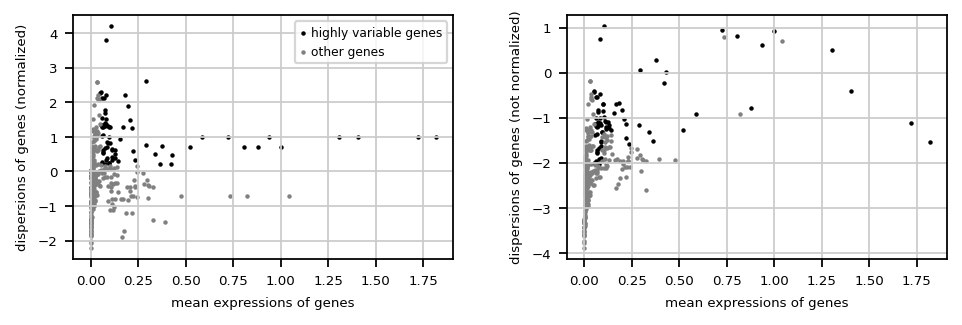

computing PCA
    on highly variable genes
    with n_comps=24
    finished (0:00:00)


/home/mm2937/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 25 × 74
    obs: 'FollicleNumber', 'Follicle_type', 'Sample', 'size'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [1470]:
# sc.pp.normalize_total(cci_cumulus_to_oocyte, target_sum = 1e4, inplace=True)
# sc.pp.log1p(cci_cumulus_to_oocyte)
sc.pp.highly_variable_genes(cci_cumulus_to_oocyte, min_disp=0.2, min_mean=0.05)
sc.pl.highly_variable_genes(cci_cumulus_to_oocyte)
# cci_cumulus_to_oocyte.raw = cci_cumulus_to_oocyte.copy()
cci_cumulus_to_oocyte = cci_cumulus_to_oocyte[:,cci_cumulus_to_oocyte.var.highly_variable]
sc.pp.scale(cci_cumulus_to_oocyte)
sc.pp.pca(cci_cumulus_to_oocyte)
cci_cumulus_to_oocyte

In [1471]:
cci_cumulus_to_oocyte.obs["Sample"] = cci_cumulus_to_oocyte.obs["Sample"].astype("category")
cci_cumulus_to_oocyte.obs["Sample"] = cci_cumulus_to_oocyte.obs["Sample"].cat.rename_categories({"4hr_replicate": "4hr"})
cci_cumulus_to_oocyte.obs["Sample"] = cci_cumulus_to_oocyte.obs["Sample"].cat.reorder_categories(["0hr", "1hr", "4hr", "6hr", "8hr", "11hr", "12hr"])

... storing 'Follicle_type' as categorical
/home/mm2937/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


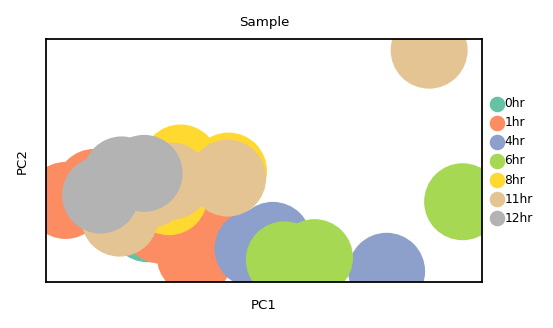

In [1472]:
sc.pl.pca(cci_cumulus_to_oocyte, color="Sample", palette="Set2")

In [1473]:
sc.tl.rank_genes_groups(cci_cumulus_to_oocyte, groupby="Sample", key_added= "rank_cci_sample", method="logreg")

ranking genes
    finished: added to `.uns['rank_cci_sample']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:00)


In [1474]:
result = cci_cumulus_to_oocyte.uns['rank_cci_sample']
groups = result['names'].dtype.names
dge_results = pd.DataFrame(
    {group: result[key][group]
    for group in groups for key in ['names']}).head(100)
print(dge_results.head(10))

              0hr             1hr             4hr             6hr  \
0    SOCS2->IL2RB  SEMA3G->PLXNA4      BTC->MAPK3    LGALS1->CD69   
1  HSD17B1->NR1I2   CYP19A1->ESR1      GAL->MAPK3     FDXR->NR1I2   
2      IL2->MAPK3      LIFR->JAK2      VCAN->SELP  TNFSF12->MAPK8   
3  CXCL12->PIK3CD   HBEGF->PIK3CD      NTS->PRKD1    SOCS2->IL2RB   
4   HSPA8->SLC6A4   INHBB->ACVR1B      ARF6->PLD1    LEPR->PRKAB1   
5    LAMA2->ITGA6    PDGFA->MAPK3     EFNB2->PAK1     EFNB1->PAK1   
6     PPIA->MAPK3     TFRC->CHEK1  ADCYAP1->MAPK3    EFNB1->ROCK1   
7     FDXR->NR1I2     NRP1->MAPK3     KDR->PIK3CD      VCAN->SELP   
8   HSD17B1->ESR1     VEGFA->CSF1     IL11->MAPK3     PENK->OPRD1   
9      ARF6->PLD1    FGF13->MAPK3     ARF6->MAPK3  ADCYAP1->MAPK3   

               8hr          11hr            12hr  
0       NPY->MAPK3  S100A6->ESR1     ANXA2->PLAT  
1      CRLF2->JAK2  EFNB1->ROCK1     IL18->MAPK8  
2     INHA->ACVR1B   SDC1->MAPK3     SDC1->MAPK3  
3  TNFRSF1A->MAPK3  ADGRE5->CD55    

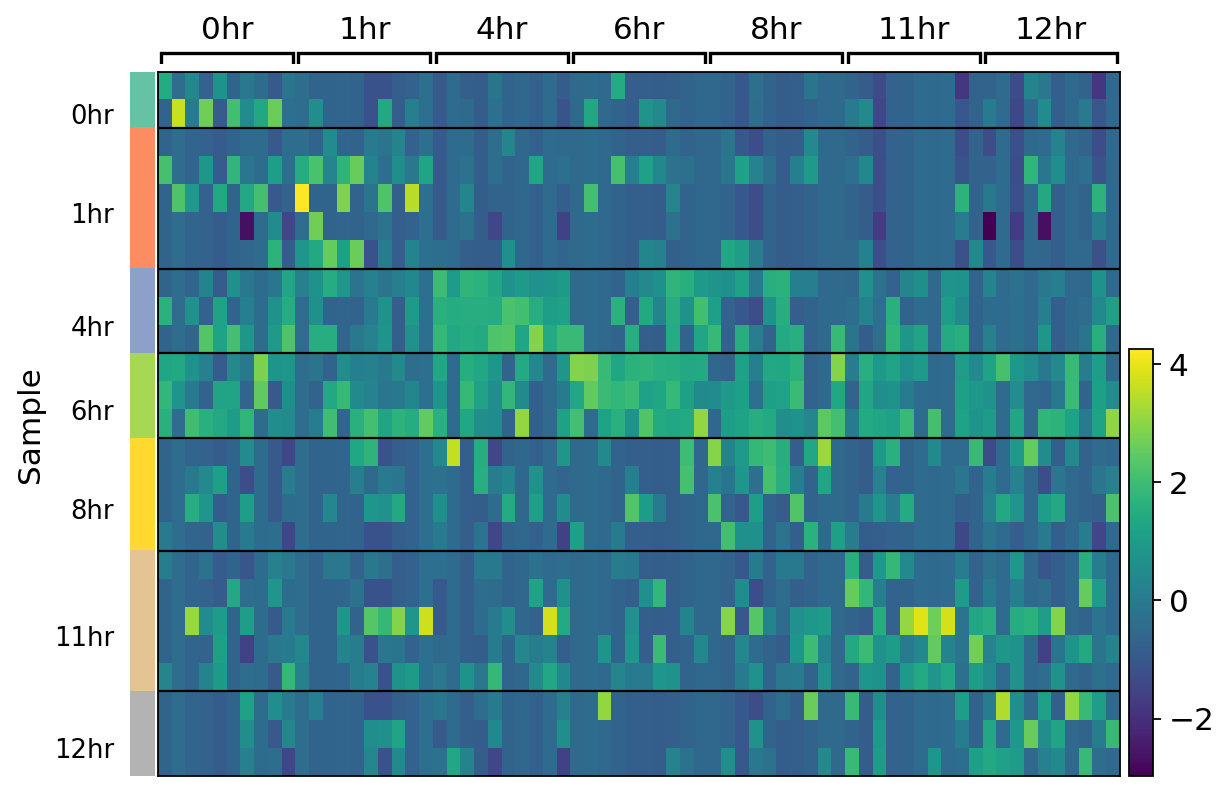

In [1475]:
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=True, figsize=(5, 5))
sc.pl.heatmap(cci_cumulus_to_oocyte, dge_results.head(10).to_dict(orient="list"), groupby="Sample")

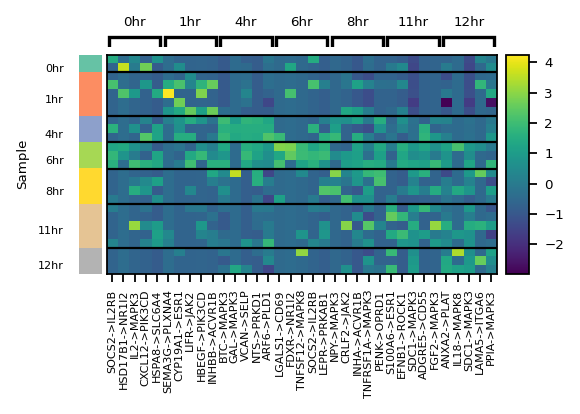

In [1476]:
sc.settings.set_figure_params(dpi=80, dpi_save=300, fontsize=6, facecolor='white', frameon=True, figsize=(3.5, 2))
sc.pl.heatmap(cci_cumulus_to_oocyte, dge_results.head(5).to_dict(orient="list"), groupby="Sample", save="cci_cumulus_to_oocyte.pdf", figsize=(3.6,2.0))

In [927]:
cci_cumulus_to_oocyte.write_h5ad("./../pyobjs/cci_cumulus_to_oocyte.h5ad")

In [1207]:
cci_cumulus_to_oocyte = sc.read_h5ad("./../pyobjs/cci_cumulus_to_oocyte.h5ad")

In [1449]:
cci_oocyte_to_cumulus = sc.read_csv("./../pyobjs/cci_oocyte_to_cumulus_means_df.csv")
cci_oocyte_to_cumulus = cci_oocyte_to_cumulus[:,pd.read_csv("./../pyobjs/oocyte_to_cumulus_gene_names.csv", index_col=0).index.values]
cci_oocyte_to_cumulus.obs = mode_df.loc[cci_oocyte_to_cumulus.obs_names]
cci_oocyte_to_cumulus

AnnData object with n_obs × n_vars = 25 × 1267
    obs: 'FollicleNumber', 'Follicle_type', 'Sample', 'size'

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


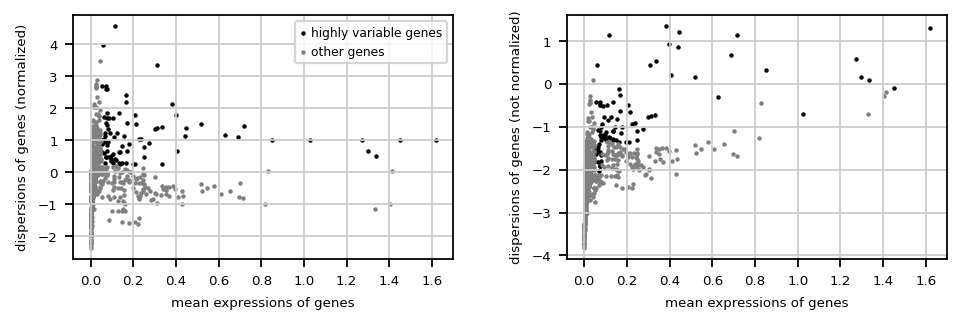

computing PCA
    on highly variable genes
    with n_comps=24
    finished (0:00:00)


/home/mm2937/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 25 × 84
    obs: 'FollicleNumber', 'Follicle_type', 'Sample', 'size'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [1450]:
# sc.pp.normalize_total(cci_oocyte_to_cumulus, target_sum = 1e4, inplace=True)
# sc.pp.log1p(cci_oocyte_to_cumulus)
sc.pp.highly_variable_genes(cci_oocyte_to_cumulus, min_disp=0.2, min_mean=0.05)
sc.pl.highly_variable_genes(cci_oocyte_to_cumulus)
# cci_oocyte_to_cumulus.raw = cci_oocyte_to_cumulus.copy()
cci_oocyte_to_cumulus = cci_oocyte_to_cumulus[:,cci_oocyte_to_cumulus.var.highly_variable]
sc.pp.scale(cci_oocyte_to_cumulus)
sc.pp.pca(cci_oocyte_to_cumulus)
cci_oocyte_to_cumulus

In [1452]:
cci_oocyte_to_cumulus.obs["Sample"] = cci_oocyte_to_cumulus.obs["Sample"].astype("category")
cci_oocyte_to_cumulus.obs["Sample"] = cci_oocyte_to_cumulus.obs["Sample"].cat.rename_categories({"4hr_replicate": "4hr"})
cci_oocyte_to_cumulus.obs["Sample"] = cci_oocyte_to_cumulus.obs["Sample"].cat.reorder_categories(["0hr", "1hr", "4hr", "6hr", "8hr", "11hr", "12hr"])

/home/mm2937/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


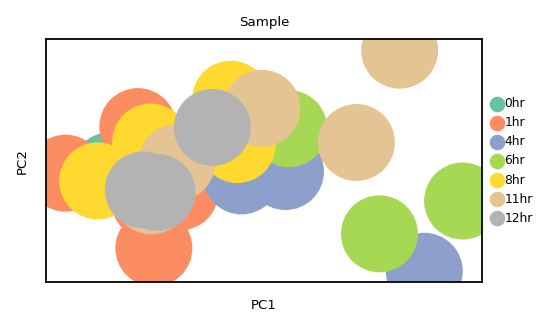

In [1453]:
sc.pl.pca(cci_oocyte_to_cumulus, color="Sample", palette="Set2")

In [1454]:
sc.tl.rank_genes_groups(cci_oocyte_to_cumulus, groupby="Sample", key_added= "rank_cci_sample", method="logreg")

ranking genes
    finished: added to `.uns['rank_cci_sample']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:00)


In [1455]:
result = cci_oocyte_to_cumulus.uns['rank_cci_sample']
groups = result['names'].dtype.names
dge_results = pd.DataFrame(
    {group: result[key][group]
    for group in groups for key in ['names']}).head(100)
print(dge_results.head(5))

            0hr            1hr            4hr            6hr           8hr  \
0     ZP3->EGFR  LAMB1->ITGA2B     FYN->PTGS2  CSF1->PLA2G4A  JAG2->NOTCH2   
1    ZP3->MERTK   LAMB1->ITGB4  LAMB1->ITGA11    SLIT1->SDC1  COL6A5->SDC1   
2  GDF9->BMPR1A       FYN->SRC       FYN->KDR  DUSP18->ITGA2  LAMC2->ITGB1   
3   LAMB1->PRNP    PTPN6->CDK1    GDF9->PTGS2   COL6A5->SDC1  LAMB1->ITGA3   
4    FYN->ITPR1    PTPN6->JAK1    CSF1->VEGFA   TGFB2->TGFB1   LAMB1->SV2C   

           11hr           12hr  
0  LAMB1->ITGA5   NTN1->PIK3R1  
1  COL6A6->SDC1     GDF9->HAS2  
2  LAMB1->ITGA1  IL23A->PIK3R1  
3  TGFB2->SPHK1    FYN->TUBA1A  
4   FYN->PECAM1  DUSP18->ITGB1  


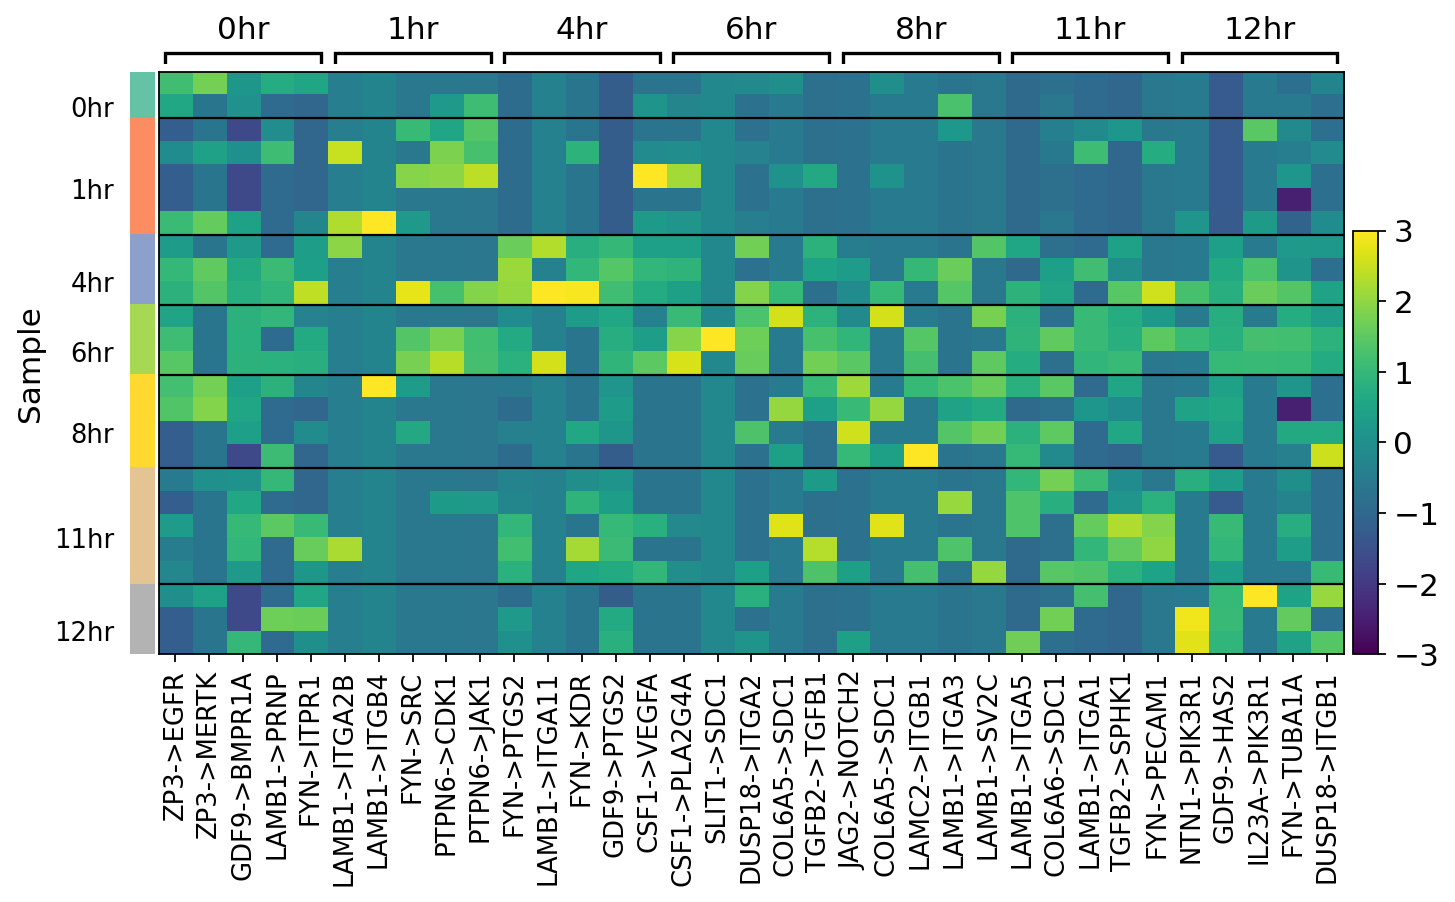

In [1456]:
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=True, figsize=(5, 5))
sc.pl.heatmap(cci_oocyte_to_cumulus, dge_results.head(5).to_dict(orient="list"), groupby="Sample", vmin=-3, vmax=3, figsize=(10,5))

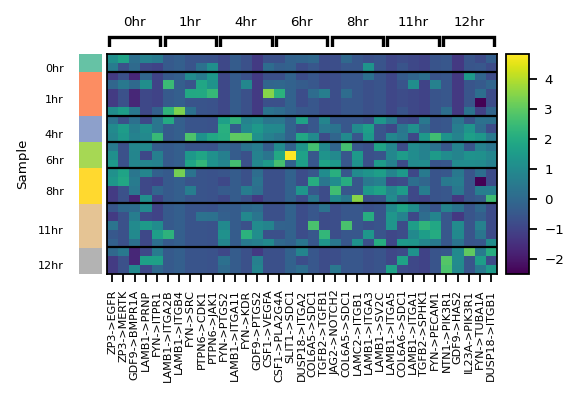

In [1459]:
sc.settings.set_figure_params(dpi=80, dpi_save=300, fontsize=6, facecolor='white', frameon=True, figsize=(3.5, 2))
sc.pl.heatmap(cci_oocyte_to_cumulus, dge_results.head(5).to_dict(orient="list"), groupby="Sample", save="cci_oocyte_to_cumulus.pdf", figsize=(3.6,2.0))

In [944]:
cci_oocyte_to_cumulus.write_h5ad("./../pyobjs/cci_oocyte_to_cumulus.h5ad")

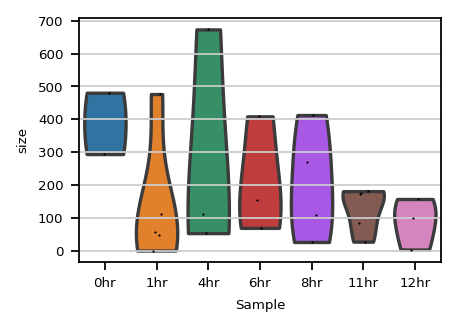

In [946]:
sc.pl.violin(cci_oocyte_to_cumulus, keys=["size"], groupby="Sample", pallete = "Set2")

In [947]:
cci_oocyte_to_cumulus.uns["Sample_colors"] = 

['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b', '#e377c2']

In [580]:
immatureovary = sc.read_h5ad("./../pyobjs/immature_ovary.h5ad")
immatureovary.uns['log1p'] = {'base' : None}

In [581]:
sq.gr.spatial_neighbors(immatureovary, coord_type="generic", radius=100)
sq.gr.nhood_enrichment(immatureovary, cluster_key="Celltypes")

Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating neighborhood enrichment using `1` core(s)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['Celltypes_nhood_enrichment']`
Finish (0:00:03)


In [608]:
sq.gr.ligrec(
    immatureovary,   
    n_perms=100,
    cluster_key="Celltypes",
    clusters=["GC_Mural-(Antral)", 'M_Dividing mesenchyme'],
    corr_method="bonferroni",
    corr_axis="interactions")

Fetching interactions from `omnipath`
Fetched `10935` interactions
    Finish (0:00:03)
Running `100` permutations on `7984` interactions and `4` cluster combinations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = data["clusters"].cat.remove_unused_categories()
/home/mm2937/.local/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = cat.rename_categories(cluster_mapper)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Performing FDR correction across the `interactions` using method `bonferroni` at level `0.05`
Adding `adata.uns['Celltypes_ligrec']`
Finish (0:00:06)


Found `25` significant interactions at level `0.001`


/home/mm2937/.local/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


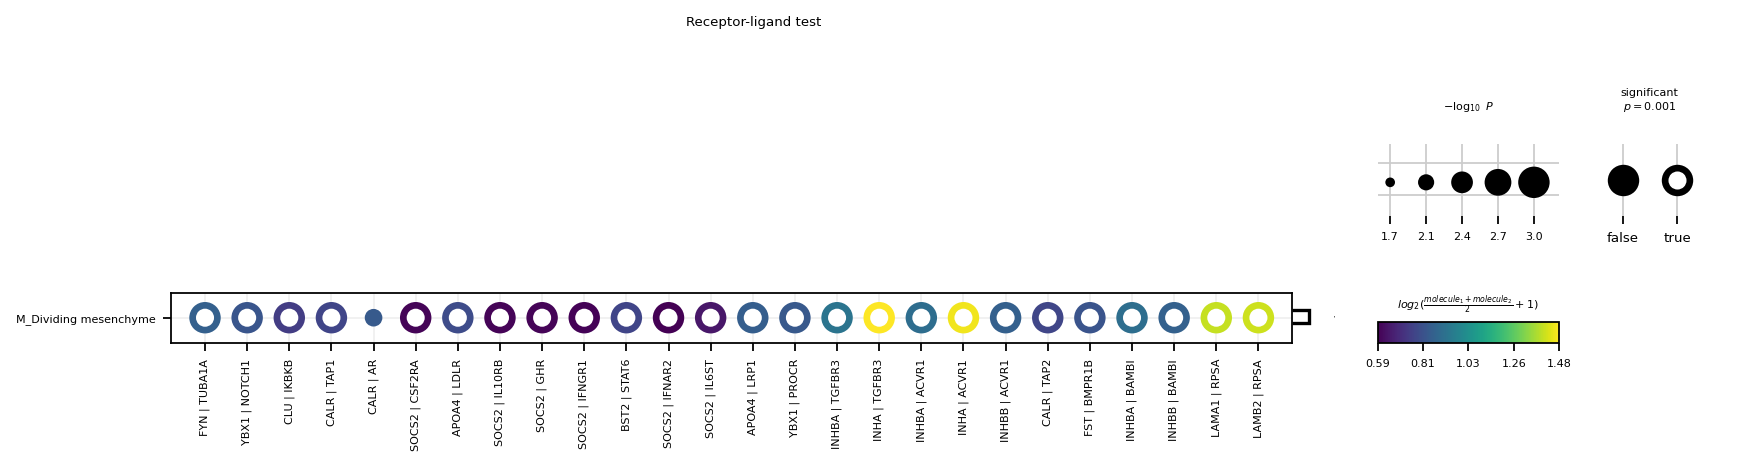

In [613]:
sc.settings.set_figure_params(dpi=80, dpi_save=80, fontsize=6, facecolor='white', frameon=True, figsize=(5, 5),)
sq.pl.ligrec(
    immatureovary,
    cluster_key="Celltypes",
    source_groups="GC_Mural-(Antral)",
    target_groups=['M_Dividing mesenchyme'],
    pvalue_threshold=0.05,
    means_range = (0.5,3.0),
    swap_axes=True, save="mesenchyme_granulosa_interactions.pdf", 
    )

In [623]:
ovary_11hr_napari = sc.read_h5ad("./../pyobjs/adata_11hr_napari_preovulatory.h5ad")
ovary_11hr_napari.uns['log1p'] = {'base' : None}
ovary_11hr_napari.shape

(11698, 2537)

In [633]:
preovulatory_follicles = [x for x in ovary_11hr_napari.obs.columns.values if x.startswith("Shapes")]
preovulatory_follicles

['Shapes [1]_shapes',
 'Shapes [2]_shapes',
 'Shapes_shapes',
 'Shapes [3]_shapes']

In [660]:
ovary_11hr = sc.read_h5ad("./../pyobjs/11hr_ovary.h5ad")
ovary_11hr.uns['log1p'] = {'base' : None}
ovary_11hr.shape

(11698, 2537)

In [661]:
preovulatory_follicles_dict = dict()
for i, preovulatory_follicle in enumerate(preovulatory_follicles):
    preovulatory_follicles_dict[i] = ovary_11hr[ovary_11hr_napari.obs[preovulatory_follicle] == True]
    print(preovulatory_follicles_dict[i].shape)

(621, 2537)
(555, 2537)
(635, 2537)
(632, 2537)


In [662]:
preovulatory_follicles_mesenchyme_dict = dict()
for i in preovulatory_follicles_dict.keys():
    print(preovulatory_follicles_dict[i].shape)
    preovulatory_follicles_mesenchyme_dict[i] = preovulatory_follicles_dict[i][preovulatory_follicles_dict[i].obs["Level0_max_pred_celltype"] == "Level0_Mesenchyme"]
    print(preovulatory_follicles_mesenchyme_dict[i].shape)

(621, 2537)
(207, 2537)
(555, 2537)
(210, 2537)
(635, 2537)
(233, 2537)
(632, 2537)
(166, 2537)


In [663]:
for i in preovulatory_follicles_mesenchyme_dict.keys():
    print(preovulatory_follicles_mesenchyme_dict[i].shape)
    sq.gr.spatial_neighbors(preovulatory_follicles_mesenchyme_dict[i], coord_type="generic", radius=100)

(207, 2537)
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
(210, 2537)
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
(233, 2537)
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
(166, 2537)
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)


In [664]:
for i in preovulatory_follicles_mesenchyme_dict.keys():
    print(preovulatory_follicles_mesenchyme_dict[i].shape)
    sq.gr.spatial_autocorr(
        preovulatory_follicles_mesenchyme_dict[i],
        mode="moran",
        genes=preovulatory_follicles_mesenchyme_dict[i].var_names[preovulatory_follicles_mesenchyme_dict[i].var.highly_variable],
        n_perms=100)

(207, 2537)
Calculating moran's statistic for `100` permutations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/scanpy/metrics/_gearys_c.py:293: UserWarning: 556 variables were constant, will return nan for these.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?/s]

Adding `adata.uns['moranI']`
Finish (0:00:04)
(210, 2537)
Calculating moran's statistic for `100` permutations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/scanpy/metrics/_gearys_c.py:293: UserWarning: 543 variables were constant, will return nan for these.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?/s]

Adding `adata.uns['moranI']`
Finish (0:00:04)
(233, 2537)
Calculating moran's statistic for `100` permutations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/scanpy/metrics/_gearys_c.py:293: UserWarning: 515 variables were constant, will return nan for these.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?/s]

Adding `adata.uns['moranI']`
Finish (0:00:04)
(166, 2537)
Calculating moran's statistic for `100` permutations using `1` core(s)


/home/mm2937/.local/lib/python3.9/site-packages/scanpy/metrics/_gearys_c.py:293: UserWarning: 667 variables were constant, will return nan for these.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?/s]

Adding `adata.uns['moranI']`
Finish (0:00:03)


In [665]:
for i in preovulatory_follicles_mesenchyme_dict.keys():
    print(preovulatory_follicles_mesenchyme_dict[i].shape)
    num_view = 12
    top_autocorr = (
        preovulatory_follicles_mesenchyme_dict[i].uns["moranI"]["I"].sort_values(ascending=False).head(num_view).index.tolist()
    )
    print(top_autocorr)

(207, 2537)
['Akr1c18', 'Hbb-bs', 'Kctd14', 'Hba-a1', 'Sfrp4', 'Hba-a2', 'Klhl22', 'Col4a4', 'Fam160a2', 'Akr1b7', 'Spg20', 'Ppp3ca']
(210, 2537)
['Hba-a2', 'Hbb-bs', 'Hba-a1', 'Krt8', 'Actg2', 'Aldh1a1', 'Hbb-bt', 'Lgals7', 'Fam171a1', 'Kctd14', 'Atg3', 'Alas2']
(233, 2537)
['Akr1c18', 'Hbb-bs', 'Aifm2', 'Col3a1', 'Lars2', 'Acta2', 'Pter', 'Sema3d', 'Scx', 'Abcg1', 'Snx19', 'Mgp']
(166, 2537)
['Trim61', 'Tshz2', 'Pim1', 'Aldh1a1', 'Sfrp4', 'Jph2', 'Fhl2', 'Psmb9', 'H1foo', 'Stc1', 'Pcsk5', 'Akr1c18']


In [666]:
preovulatory_follicles_mesenchyme_dict[0]

AnnData object with n_obs × n_vars = 207 × 2537
    obs: 'barcode', 'x', 'y', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'individual_leiden_1.0', 'individual_leiden_1.2', 'individual_leiden_1.5', 'Sample', 'S_score', 'G2M_score', 'phase', 'leiden_1.0', 'leiden_1.5', 'Level1_total_abundance', 'Level1_EN_Blood', 'Level1_EN_Lymph', 'Level1_Epithelium', 'Level1_GC_Antral', 'Level1_GC_Atretic', 'Level1_GC_CL_Active', 'Level1_GC_CL_Lytic', 'Level1_GC_Estrous', 'Level1_GC_Mitotic', 'Level1_GC_Mural', 'Level1_GC_Preantral', 'Level1_I_B_Cell', 'Level1_I_Dendritic_Cell', 'Level1_I_Granulocyte', 'Level1_I_Macrophage', 'Level1_I_T_Cell', 'Level1_M_Cortical Stroma', 'Level1_M_Dividing Mesenchyme', 'Level1_M_Immature Theca', 'Level1_M_Medullary Stroma', 'Level1_M_Pericyte', 'Level1_M_Smooth Muscle', 'Level1_M_Steroidogenic Theca', 'Level1_Oocyte', 'Level1_max_pred', 'Level1_max_pred_celltype', 'Level1_max_pred_celltype_group', 'Level0_total_abundance', 'Leve

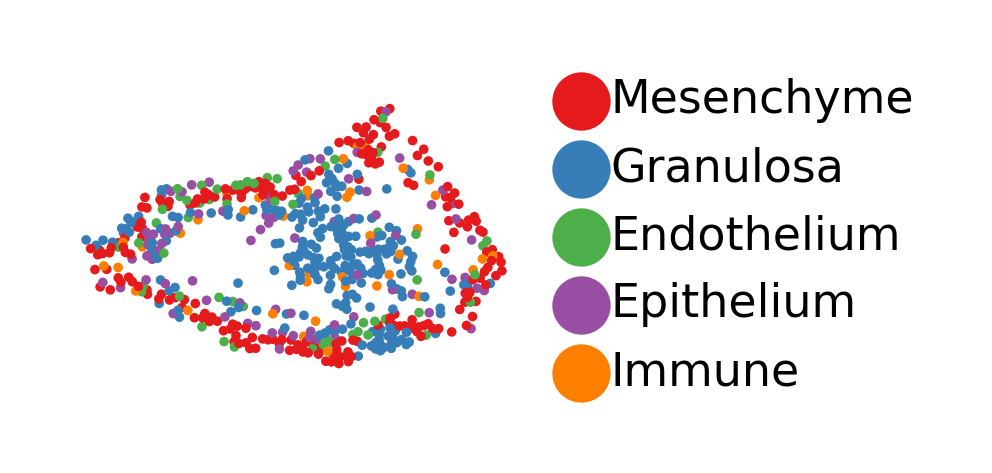

In [670]:
sc.settings.set_figure_params(dpi=300, dpi_save= 300, fontsize=6, facecolor='white', frameon=False, figsize=(1.0, 1.0), vector_friendly = True, transparent=True, format="pdf")
from pylab import *
cmap = cm.get_cmap('Set1', 10)
palette_custom = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]
grouping_var = "BroadCelltype"
sc.pl.spatial(preovulatory_follicles_dict[0], color=grouping_var, palette=palette_custom, spot_size=30, frameon=False, wspace=0.3, na_color="lightgray", na_in_legend=False, title="", save = "preovulatory_broad_celltypes")

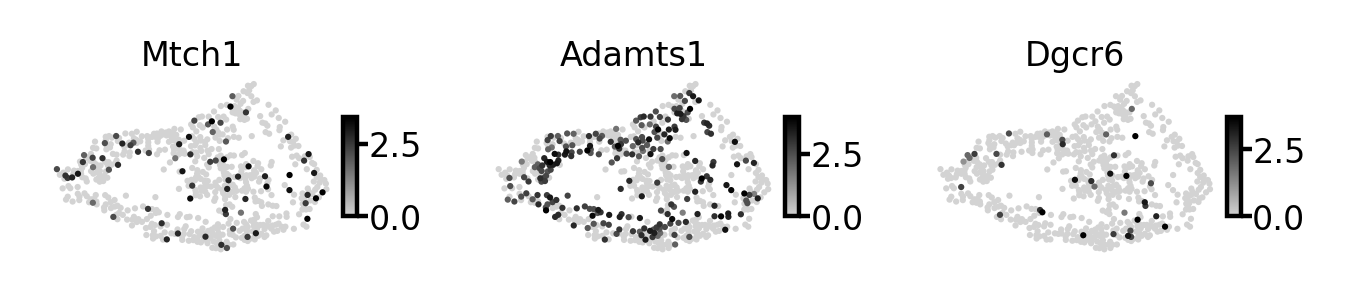

In [951]:
sc.settings.set_figure_params(dpi=200, dpi_save=300, facecolor='white', fontsize=6, frameon=True, figsize=(1.0, 1.0), format="pdf")
fig, axs = plt.subplots(1,3, figsize = (3.5,1.0))
axs = axs.flatten()
for i, gene in enumerate(["Mtch1", "Adamts1", "Dgcr6"]):
    sc.pl.spatial(preovulatory_follicles_dict[0], color=gene, spot_size=30, frameon=False, wspace=0.1, ncols=5, cmap=sns.blend_palette(["lightgrey", sns.xkcd_rgb["black"]], as_cmap=True), vmax="p99.2", ax=axs[i], show=False)
    axs[i].set_title(axs[i].get_title(), pad=0)
for i in range(1,4):
    mappable = fig.axes[-i].collections[1]
    colorBar = fig.axes[-i]
    colorBar.remove()
    plt.colorbar(mappable=mappable, ax=axs[-i],
                 fraction=0.25, aspect=7, location = "right",
                 pad=0 ,shrink = 0.3)
for i in range(1,4):
    fig.axes[-i].tick_params(length = 2, pad = 0.0)
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
# plt.show()
plt.savefig("./figures/preovulatory_apex.pdf")

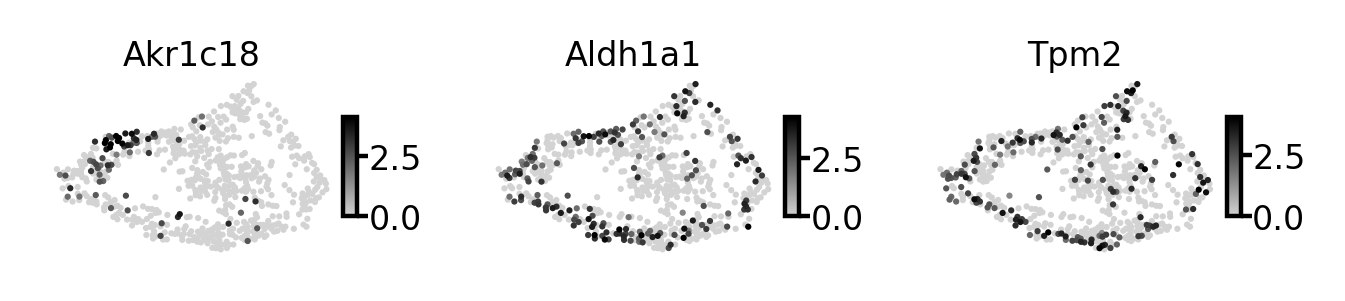

In [950]:
sc.settings.set_figure_params(dpi=200, dpi_save=300, facecolor='white', fontsize=6, frameon=True, figsize=(1.0, 1.0), format="pdf")
fig, axs = plt.subplots(1,3, figsize = (3.5,1.0))
axs = axs.flatten()
for i, gene in enumerate(["Akr1c18", "Aldh1a1", "Tpm2"]):
    sc.pl.spatial(preovulatory_follicles_dict[0], color=gene, spot_size=30, frameon=False, wspace=0.1, ncols=5, cmap=sns.blend_palette(["lightgrey", sns.xkcd_rgb["black"]], as_cmap=True), vmax="p99.2", ax=axs[i], show=False)
    axs[i].set_title(axs[i].get_title(), pad=0)
for i in range(1,4):
    mappable = fig.axes[-i].collections[1]
    colorBar = fig.axes[-i]
    colorBar.remove()
    plt.colorbar(mappable=mappable, ax=axs[-i],
                 fraction=0.25, aspect=7, location = "right",
                 pad=0 ,shrink = 0.3)
for i in range(1,4):
    fig.axes[-i].tick_params(length = 2, pad = 0.0)
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
# plt.show()
plt.savefig("./figures/preovulatory_base.pdf")